Nikita Kotelevskii

tg: @nktlvsk

# Simple Uncertainty Quantification Methods

# Виды неопределённости

![Sources of uncertainty](./epistemic_vs_aleatoric.png)

## Алеаторная неопределённость

Алеаторная (aleatoric) неопределенность эта та часть предсказательной неопределённости, которая связана с присущим данным шумом или неотъемлемой случайностью. Характерной особенностью этой неопределённости является то, что её невозможно уменьшить добавив больше данных или усложнив модель.


Примерами неотъемлемой случайности в данных является предсказание случайного результата -- например бросок монеты.

В контексте машинного обучения алеаторную неопределенность можно далее разделить на две категории:

1. ** Гомоскедастическая неопределенность: ** Этот тип алеаторной неопределенности остается постоянным в различных точках входных данных. Обычно это происходит, когда шум в данных относительно однороден на разных входных данных. Например, при измерении роста отдельных людей погрешность измерения, вероятно, будет достаточно постоянной, что приведет к гомоскедастической неопределенности.

2. ** Гетероскедастическая неопределенность: ** Этот тип алеаторной неопределенности изменяется в зависимости от входных данных. Обычно это происходит, когда шум в данных меняется в зависимости от входных данных. Например, в задаче прогнозирования цен на жилье уровень неопределенности может быть выше для домов класса люкс (из-за меньшего количества продаж и большей изменчивости цен) по сравнению с домами средней стоимости.

Понимание и учет алеаторной неопределенности имеет важное значение во многих задачах машинного обучения для принятия надежных прогнозов и решений. Такие методы, как MaxProb и другие, используются для количественной оценки этой неопределенности и включения ее в выходные данные моделей машинного обучения.

## Эпистемическая неопределённость

Эпистемическая (epistemic) неопределенность возникает из-за недостатка знаний. В отличие от алеаторной неопределенности, которая присуща данным, эпистемическую неопределенность потенциально можно уменьшить, собрав больше данных, улучшив наши модели или собрав больше информации о рассматриваемой проблеме.

Эпистемическая неопределенность обычно возникает, когда мы имеем дело со сложными явлениями, которые наши модели не могут полностью охватить, или когда у нас есть ограниченные данные, на основе которых наши модели учатся. Неопределенность, по сути, проистекает из нашего непонимания или незнания истинного процесса, лежащего в основе получения данных.

Например, в контексте машинного обучения:

1. Если мы обучаем модель на небольшом наборе данных, модель может хорошо работать с обучающими данными, но плохо с невидимыми данными, что иллюстрирует высокую эпистемическую неопределенность. Собирая больше обучающих данных, мы потенциально можем уменьшить эту неопределенность.

2. Если мы используем упрощенную модель (например, линейную регрессию) для задачи, где истинная взаимосвязь сложна и нелинейна, предсказания модели будут иметь высокую эпистемическую неопределенность. Используя более сложную модель (например, глубокую нейронную сеть), мы потенциально можем лучше уловить сложность и уменьшить эту неопределенность.

## Maximum Probability (MaxProb)

Метод максимальной вероятности (MaxProb) - это простой подход к количественной оценке (алеаторической) неопределенности, которая представляет собой присущий данным шум или случайность. В основном он используется в задачах классификации, где модели выводят распределение вероятностей по возможным классам.

В MaxProb неопределенность модели в отношении прогноза оценивается с учетом максимальной выходной вероятности. Более высокая максимальная вероятность соответствует меньшей неопределенности и более уверенному прогнозу. И наоборот, более низкая максимальная вероятность указывает на больший уровень неопределенности.

Этот метод предполагает, что вероятности, выводимые моделью, хорошо откалиброваны. Однако это не дает оценки эпистемологической неопределенности, которая обусловлена недостатком наших знаний и потенциально может быть уменьшена с помощью большего количества данных или более сложной модели.


In [1]:
!git clone https://github.com/wjmaddox/swa_gaussian.git
!git clone https://github.com/hollance/reliability-diagrams.git
!git clone https://github.com/gpleiss/temperature_scaling.git
# !git clone https://github.com/nkotelevskii/helpers.git

fatal: destination path 'swa_gaussian' already exists and is not an empty directory.
fatal: destination path 'reliability-diagrams' already exists and is not an empty directory.
fatal: destination path 'temperature_scaling' already exists and is not an empty directory.


In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import torch.nn.functional as F
from scipy.stats import entropy

import os

from typing import Union

import sys
sys.path.insert(0, './reliability-diagrams/')

from reliability_diagrams import reliability_diagram
from torch.nn.functional import softmax
from preresnet import PreResNet20

In [3]:
# Compute the entropy and MaxProb scores
def compute_scores(model, data_loader, device):
    entropy_scores = []
    maxprob_scores = []
    with torch.no_grad():
        for data in data_loader:
            images, _ = data
            images = images.to(device)
            outputs = model(images)
            probabilities = F.softmax(outputs, dim=1)
            entropy_scores.extend(entropy(probabilities.cpu().numpy(), axis=1).tolist())
            maxprob_scores.extend((1 - np.max(probabilities.cpu().numpy(), axis=1)).tolist())
    return entropy_scores, maxprob_scores

In [4]:
# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Load the pretrained model
# model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar100_resnet20", pretrained=True).to(device)

MODEL_INDEX = 0

model_conf = PreResNet20()
model = model_conf.base(*model_conf.args, num_classes=100, **model_conf.kwargs)
model.load_state_dict(torch.load(f'./ensembles/preresnet20-{MODEL_INDEX}.pth', map_location=device))
model = model.to(device)
model.eval()
print("OK!")

OK!


In [5]:
# Define the transform
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        (0.5070751592371323, 0.48654887331495095, 0.4409178433670343),
        (0.2673342858792401, 0.2564384629170883, 0.27615047132568404)
        )
])

# Load the CIFAR100 train dataset
cifar100_train = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
# Load the CIFAR100 validation dataset
cifar100_valid = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)
# Load the CIFAR10 validation dataset
cifar10_valid = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [6]:
# Split the CIFAR100 validation set into a new validation set and a calibration set
cal_proportion = 0.25
indices = list(range(len(cifar100_valid)))
np.random.shuffle(indices)
split = int(np.floor(cal_proportion * len(cifar100_valid)))

calibration_idx, validation_idx = indices[:split], indices[split:]
calibration_sampler = torch.utils.data.SubsetRandomSampler(calibration_idx)
validation_sampler = torch.utils.data.SubsetRandomSampler(validation_idx)

In [7]:
# Create dataloaders
batch_size = 100
cifar100_trainloader = torch.utils.data.DataLoader(cifar100_train, batch_size=10 * batch_size, shuffle=True)
cifar100_valloader = torch.utils.data.DataLoader(cifar100_valid, batch_size=batch_size, sampler=validation_sampler, shuffle=False)
cifar100_calloader = torch.utils.data.DataLoader(cifar10_valid, batch_size=batch_size, sampler=calibration_sampler, shuffle=False)
cifar10_valloader = torch.utils.data.DataLoader(cifar10_valid, batch_size=batch_size, shuffle=False)

In [8]:
# Compute scores for CIFAR100
cifar100_entropy_scores, cifar100_maxprob_scores = compute_scores(model, cifar100_valloader, device)

# Compute scores for CIFAR10
cifar10_entropy_scores, cifar10_maxprob_scores = compute_scores(model, cifar10_valloader, device)

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

In [10]:
def plot_histogram_eq_width(data1: list | np.ndarray, data2: list | np.ndarray, title:str, ) -> None:
    # Define the common bins
    bins = np.linspace(min(min(data1), min(data2)), max(max(data1), max(data2)), num=20)
    
    plt.close()
    plt.figure(figsize=(5, 3), dpi=150)
    # Plot histograms
    plt.hist(data1, bins=bins, alpha=0.5, label='InD')
    plt.hist(data2, bins=bins, alpha=0.5, label='OOD')
    
    labels = np.hstack([np.zeros(len(data1)), np.ones(len(data2))])
    scores = np.hstack([data1, data2])
    
    plt.title(title)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()
    
    print("ROC AUC: ", round(roc_auc_score(labels, scores), 3))

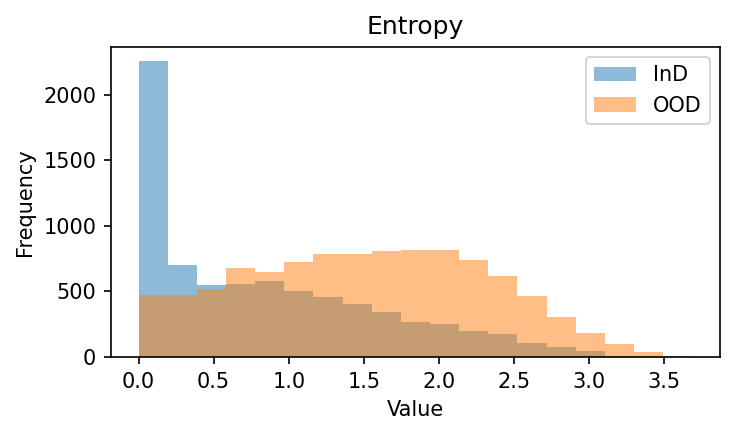

ROC AUC:  0.733


In [11]:
plot_histogram_eq_width(data1=cifar100_entropy_scores, data2=cifar10_entropy_scores, title="Entropy")

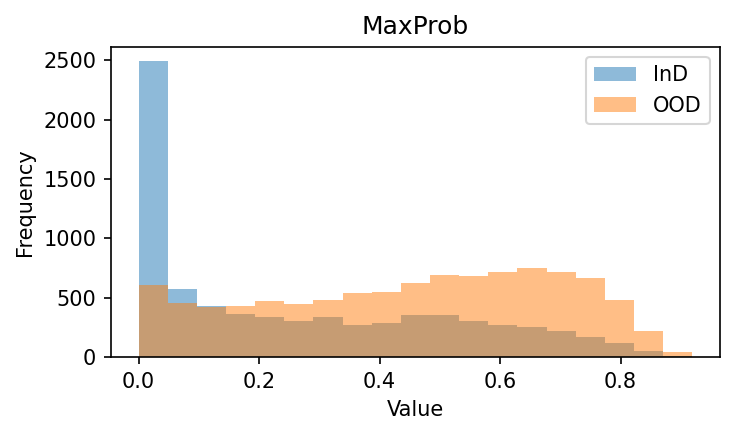

ROC AUC:  0.721


In [12]:
plot_histogram_eq_width(data1=cifar100_maxprob_scores, data2=cifar10_maxprob_scores, title="MaxProb")

# Калибровка предсказаний нейросетей

**On Calibration of Modern Neural Networks**

https://proceedings.mlr.press/v70/guo17a/guo17a.pdf

Добавить метрики
Что хуже, over confidence или over accuracy?

In [13]:
def collect_labels_and_probs(model_, dataloader, device):
    model_.eval()
    all_labels = []
    all_probs = []
    with torch.no_grad():
        for data in dataloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model_(images)
            probs = softmax(outputs, dim=1)
            all_labels.append(labels.cpu().numpy())
            all_probs.append(probs.cpu().numpy())
    return np.hstack(all_labels), np.vstack(all_probs)

In [14]:
labels, probs = collect_labels_and_probs(model_=model, dataloader=cifar100_valloader, device=device)

/home/nkotelevskii/github/helpers/./reliability-diagrams/reliability_diagrams.py:177: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels(new_ticks)


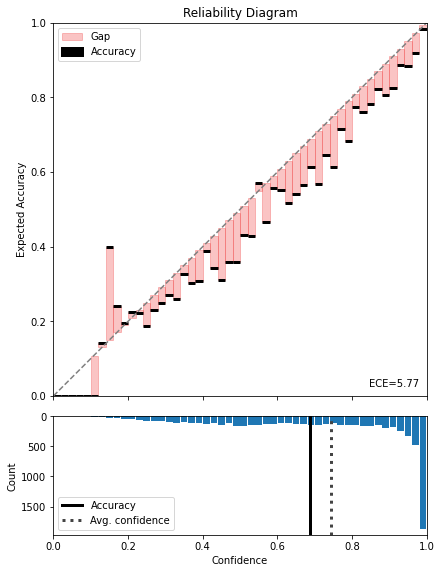

In [15]:
reliability_diagram(
    true_labels=labels,
    pred_labels=np.argmax(probs, axis=-1),
    confidences=probs[np.arange(len(probs)),
                      np.argmax(probs, axis=-1)
                      ],
     num_bins=50
    )

## Попробуем откалибровать нашу модель

In [16]:
from temperature_scaling.temperature_scaling import ModelWithTemperature
from copy import deepcopy

In [17]:
calibrated_model = ModelWithTemperature(deepcopy(model))
calibrated_model.set_temperature(cifar100_calloader)
calibrated_model.eval()
print("OK!")

Before temperature - NLL: 10.178, ECE: 0.538
Optimal temperature: 1.836
After temperature - NLL: 6.524, ECE: 0.299
OK!


In [18]:
labels, calibrated_probs = collect_labels_and_probs(model_=calibrated_model, dataloader=cifar100_valloader, device=device)

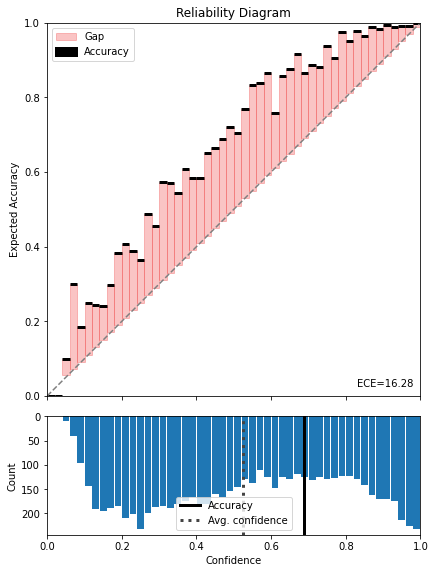

In [19]:
reliability_diagram(
    true_labels=labels,
    pred_labels=np.argmax(calibrated_probs, axis=-1),
    confidences=calibrated_probs[
        np.arange(len(calibrated_probs)),
        np.argmax(calibrated_probs, axis=-1)
                      ],
     num_bins=50
    )

In [20]:
# Compute scores for CIFAR100
cifar100_entropy_scores_cal, cifar100_maxprob_scores_cal = compute_scores(calibrated_model, cifar100_valloader, device)

# Compute scores for CIFAR10
cifar10_entropy_scores_cal, cifar10_maxprob_scores_cal = compute_scores(calibrated_model, cifar10_valloader, device)

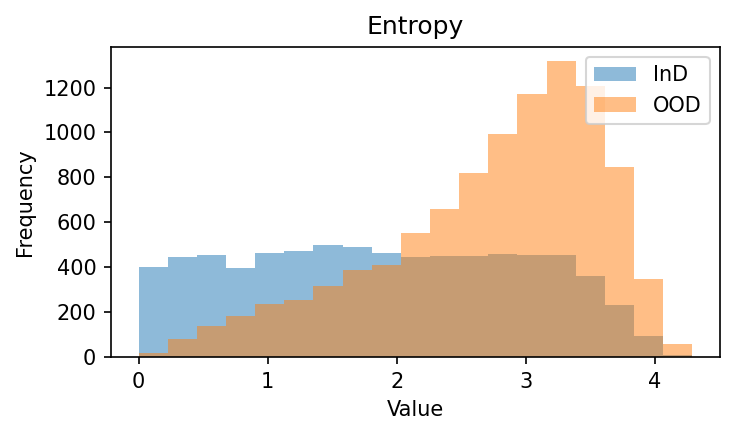

ROC AUC:  0.724


In [21]:
plot_histogram_eq_width(data1=cifar100_entropy_scores_cal, data2=cifar10_entropy_scores_cal, title="Entropy")

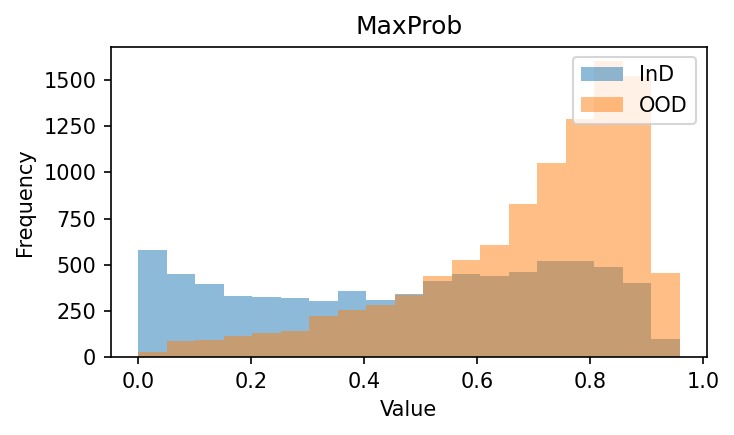

ROC AUC:  0.732


In [22]:
plot_histogram_eq_width(data1=cifar100_maxprob_scores_cal, data2=cifar10_maxprob_scores_cal, title="MaxProb")

Вопросы:

Влияет ли калибровка на accuracy?

Что лучше -- overconfidence или underconfidence?

Рассказать, что для алеаторной неопределённости есть таргет, а для epistemic его нет



# Ансамбли нейронных сетей (Deep emsembles)

https://proceedings.neurips.cc/paper_files/paper/2017/file/9ef2ed4b7fd2c810847ffa5fa85bce38-Paper.pdf

Lakshminarayanan B., Pritzel A., Blundell C. Simple and scalable predictive uncertainty estimation using deep ensembles //Advances in neural information processing systems. – 2017. – Т. 30.


In [23]:
def load_emsembles(path: str = './ensembles/'):
    models = []
    for filename in os.listdir(path):
        if filename.endswith('.pth'):
            model_conf_ = PreResNet20()
            model_ = model_conf.base(*model_conf_.args, num_classes=100, **model_conf_.kwargs)
            model_.load_state_dict(torch.load(os.path.join(path, filename)))
            model_ = model_.to(device)
            model_.eval()
            models.append(model_)
    return models

In [24]:
def collect_labels_and_probs_ensemble(ensemble_, dataloader, device):
    all_labels = []
    all_probs = []
    with torch.no_grad():
        for data in dataloader:
            images, labels = data[0].to(device), data[1].to(device)
            probs_batch = []
            for model_ in ensemble_:
                outputs = model_(images)
                probs = softmax(outputs, dim=1)
                probs_batch.append(probs.cpu().numpy()[None])

            all_probs.append(np.mean(np.vstack(probs_batch), axis=0))
            all_labels.append(labels.cpu().numpy())
    return np.hstack(all_labels), np.vstack(all_probs)


In [25]:
# Compute the entropy and MaxProb scores
def compute_scores_ensemble(ensemble, data_loader, device):
    mean_entropy_scores = []
    entropy_mean_scores = []
    maxprob_scores = []
    bald = []
    with torch.no_grad():
        for data in data_loader:
            images, _ = data
            images = images.to(device)

            single_model_probabilities = []
            for model in ensemble:
                outputs = model(images)
                probabilities = F.softmax(outputs, dim=1).cpu().numpy()
                single_model_probabilities.append(probabilities[None])

            entropy_mean_scores.extend(entropy(np.mean(np.vstack(single_model_probabilities), axis=0), axis=1).tolist())
            mean_entropy_scores.extend(np.mean(entropy(np.vstack(single_model_probabilities), axis=-1), axis=0).tolist())
            maxprob_scores.extend((1 - np.max(np.mean(np.vstack(single_model_probabilities), axis=0), axis=1)).tolist())

    return mean_entropy_scores, entropy_mean_scores, maxprob_scores

In [26]:
ensemble = load_emsembles()

In [27]:
labels, ensemble_probs = collect_labels_and_probs_ensemble(ensemble_=ensemble, dataloader=cifar100_valloader, device=device)

/home/nkotelevskii/github/helpers/./reliability-diagrams/reliability_diagrams.py:177: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels(new_ticks)


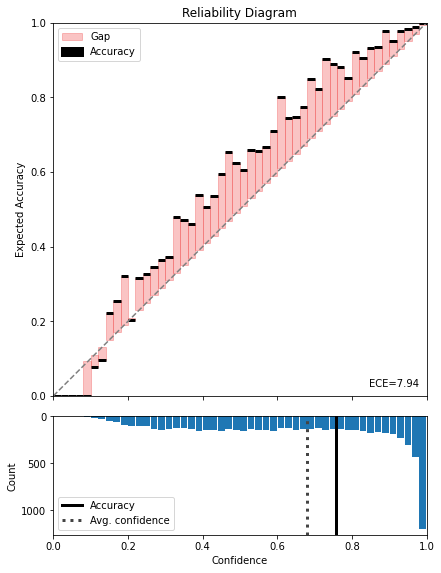

In [28]:
reliability_diagram(
    true_labels=labels,
    pred_labels=np.argmax(ensemble_probs, axis=-1),
    confidences=ensemble_probs[
        np.arange(len(ensemble_probs)),
        np.argmax(ensemble_probs, axis=-1)
                      ],
     num_bins=50
    )

In [29]:
# Compute scores for CIFAR100
cifar100_EH_ensemble, cifar100_HE_ensemble, cifar100_maxprob_ensemble = compute_scores_ensemble(ensemble, cifar100_valloader, device)

# Compute scores for CIFAR10
cifar10_EH_ensemble, cifar10_HE_ensemble, cifar10_maxprob_ensemble = compute_scores_ensemble(ensemble, cifar10_valloader, device)

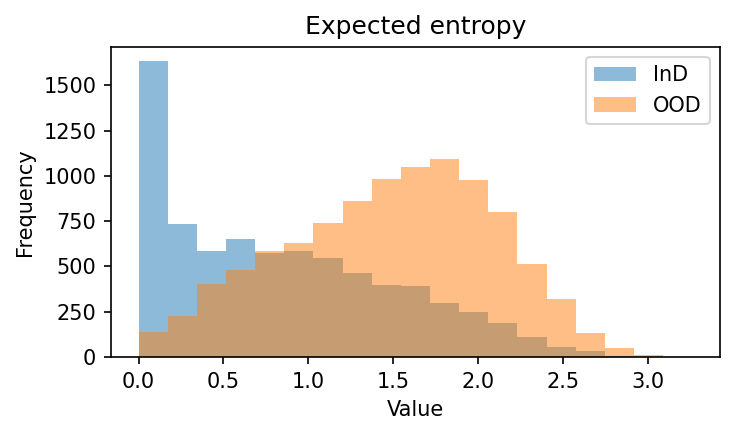

ROC AUC:  0.76


In [30]:
plot_histogram_eq_width(data1=cifar100_EH_ensemble, data2=cifar10_EH_ensemble, title="Expected entropy")

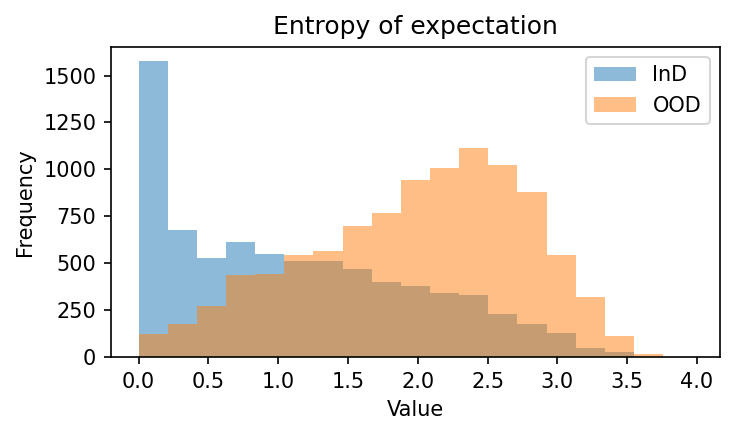

ROC AUC:  0.768


In [31]:
plot_histogram_eq_width(data1=cifar100_HE_ensemble, data2=cifar10_HE_ensemble, title="Entropy of expectation")

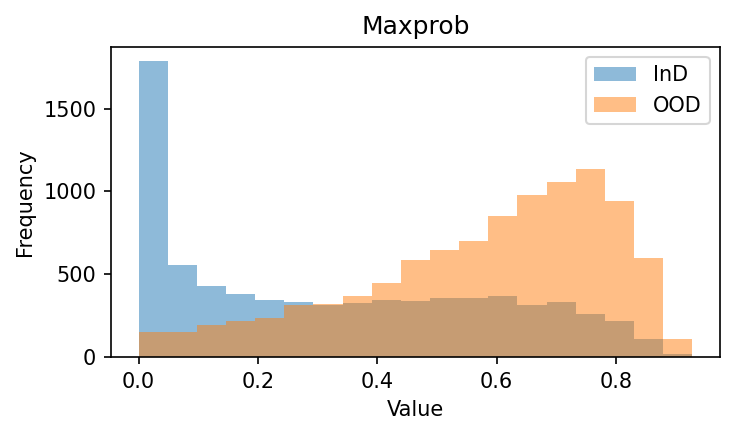

ROC AUC:  0.767


In [32]:
plot_histogram_eq_width(data1=cifar100_maxprob_ensemble, data2=cifar10_maxprob_ensemble, title="Maxprob")

## Давайте откалибруем каждую модель в ансамбле !

In [33]:
def ensemble_calibration(ensemble, calloader):
    calibrated_ensemble = []
    for model in ensemble:
        calibrated_model = ModelWithTemperature(deepcopy(model))
        calibrated_model.set_temperature(calloader)
        calibrated_model.eval()
        calibrated_ensemble.append(calibrated_model)
    return calibrated_ensemble

In [34]:
calibrated_ensemble = ensemble_calibration(ensemble=ensemble, calloader=cifar100_calloader)

Before temperature - NLL: 10.311, ECE: 0.553
Optimal temperature: 1.837
After temperature - NLL: 6.572, ECE: 0.313
Before temperature - NLL: 10.867, ECE: 0.553
Optimal temperature: 1.843
After temperature - NLL: 6.861, ECE: 0.316
Before temperature - NLL: 10.178, ECE: 0.538
Optimal temperature: 1.836
After temperature - NLL: 6.524, ECE: 0.299
Before temperature - NLL: 10.409, ECE: 0.545
Optimal temperature: 1.838
After temperature - NLL: 6.641, ECE: 0.305
Before temperature - NLL: 10.459, ECE: 0.541
Optimal temperature: 1.839
After temperature - NLL: 6.675, ECE: 0.304
Before temperature - NLL: 10.396, ECE: 0.551
Optimal temperature: 1.838
After temperature - NLL: 6.625, ECE: 0.307
Before temperature - NLL: 10.284, ECE: 0.541
Optimal temperature: 1.837
After temperature - NLL: 6.584, ECE: 0.301
Before temperature - NLL: 10.364, ECE: 0.545
Optimal temperature: 1.836
After temperature - NLL: 6.621, ECE: 0.301
Before temperature - NLL: 10.331, ECE: 0.549
Optimal temperature: 1.839
After te

In [35]:
labels, calibrated_ensemble_probs = collect_labels_and_probs_ensemble(ensemble_=calibrated_ensemble, dataloader=cifar100_valloader, device=device)

/home/nkotelevskii/github/helpers/./reliability-diagrams/reliability_diagrams.py:177: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels(new_ticks)


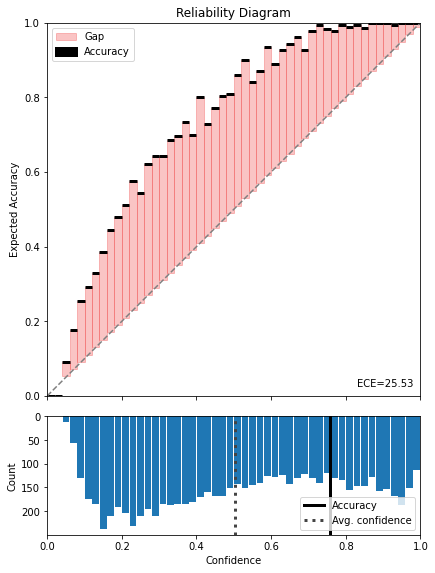

In [36]:
reliability_diagram(
    true_labels=labels,
    pred_labels=np.argmax(calibrated_ensemble_probs, axis=-1),
    confidences=calibrated_ensemble_probs[
        np.arange(len(calibrated_ensemble_probs)),
        np.argmax(calibrated_ensemble_probs, axis=-1)
                      ],
     num_bins=50
    )

In [37]:
# Compute scores for CIFAR100
cifar100_EH_cal_ensemble, cifar100_HE_cal_ensemble, cifar100_maxprob_cal_ensemble = compute_scores_ensemble(calibrated_ensemble, cifar100_valloader, device)

# Compute scores for CIFAR10
cifar10_EH_cal_ensemble, cifar10_HE_cal_ensemble, cifar10_maxprob_cal_ensemble = compute_scores_ensemble(calibrated_ensemble, cifar10_valloader, device)

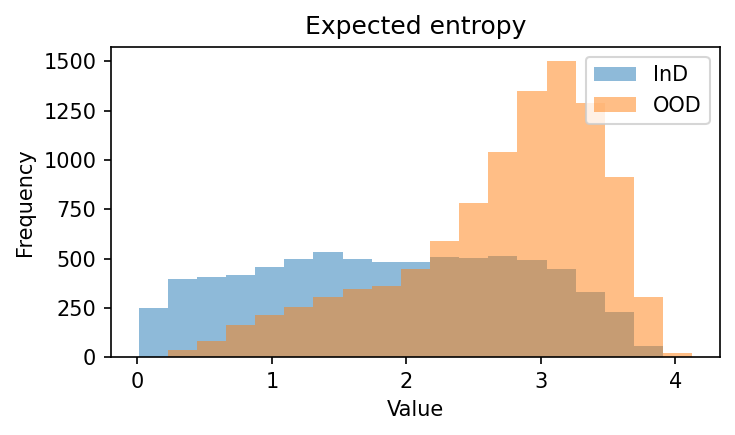

ROC AUC:  0.743


In [38]:
plot_histogram_eq_width(data1=cifar100_EH_cal_ensemble, data2=cifar10_EH_cal_ensemble, title="Expected entropy")

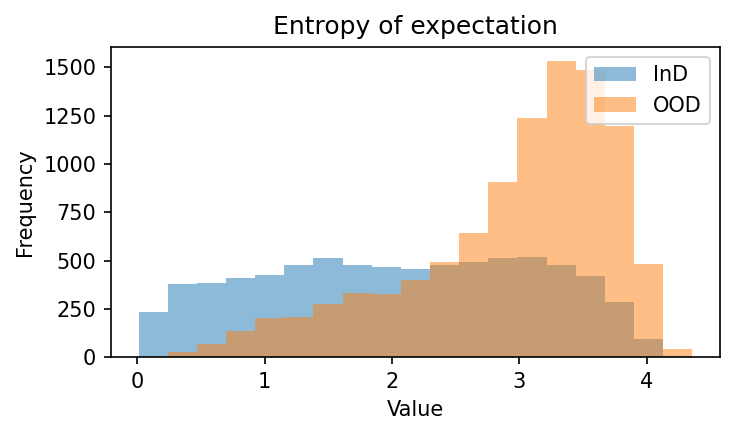

ROC AUC:  0.747


In [39]:
plot_histogram_eq_width(data1=cifar100_HE_cal_ensemble, data2=cifar10_HE_cal_ensemble, title="Entropy of expectation")

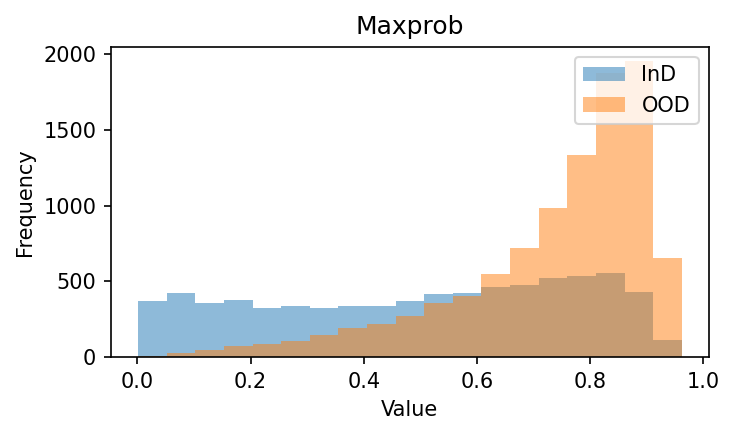

ROC AUC:  0.764


In [40]:
plot_histogram_eq_width(data1=cifar100_maxprob_cal_ensemble, data2=cifar10_maxprob_cal_ensemble, title="Maxprob")

# Monte-Carlo Dropout

http://proceedings.mlr.press/v48/gal16.pdf

Gal, Yarin, and Zoubin Ghahramani. "Dropout as a bayesian approximation: Representing model uncertainty in deep learning." international conference on machine learning. PMLR, 2016.

In [41]:
from preresnet_dropout import PreResNet20Drop

In [42]:
model_drop_conf = PreResNet20Drop()
model_drop = model_drop_conf.base(*model_drop_conf.args, num_classes=100, **model_drop_conf.kwargs)
model_drop.load_state_dict(torch.load(f'./preresnetdrop20-0.pth'))
model_drop = model_drop.to(device)
#
# model.eval()
model.train()
#
print("OK!")

OK!


In [43]:
N_MC_DROP_SAMPLES = 20

In [44]:
def collect_labels_and_probs_mcdropout(mc_model, dataloader, n_samples, device):
    mc_model.train()
    all_labels = []
    all_probs = []
    with torch.no_grad():
        for data in dataloader:
            images, labels = data[0].to(device), data[1].to(device)

            prob_samples = []
            for _ in range(n_samples):
                outputs = mc_model(images)
                probs = softmax(outputs, dim=1)
                prob_samples.append(probs.cpu().numpy()[None])

            all_labels.append(labels.cpu().numpy())
            all_probs.append(np.mean(np.vstack(prob_samples), axis=0))
    return np.hstack(all_labels), np.vstack(all_probs)

In [45]:
# Compute the entropy and MaxProb scores
def compute_scores_mcdropout(mc_model, data_loader, n_samples, device):
    mc_model.train()
    mean_entropy_scores = []
    entropy_mean_scores = []
    maxprob_scores = []
    bald = []
    with torch.no_grad():
        for data in data_loader:
            images, _ = data
            images = images.to(device)

            single_model_probabilities = []
            for _ in range(n_samples):
                outputs = mc_model(images)
                probabilities = F.softmax(outputs, dim=1).cpu().numpy()
                single_model_probabilities.append(probabilities[None])

            entropy_mean_scores.extend(entropy(np.mean(np.vstack(single_model_probabilities), axis=0), axis=1).tolist())
            mean_entropy_scores.extend(np.mean(entropy(np.vstack(single_model_probabilities), axis=-1), axis=0).tolist())
            maxprob_scores.extend((1 - np.max(np.mean(np.vstack(single_model_probabilities), axis=0), axis=1)).tolist())

    return mean_entropy_scores, entropy_mean_scores, maxprob_scores

In [46]:
labels, probs_mcdropout = collect_labels_and_probs_mcdropout(mc_model=model_drop,
                                                             dataloader=cifar100_valloader,
                                                             n_samples=N_MC_DROP_SAMPLES, device=device)

/home/nkotelevskii/github/helpers/./reliability-diagrams/reliability_diagrams.py:177: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels(new_ticks)


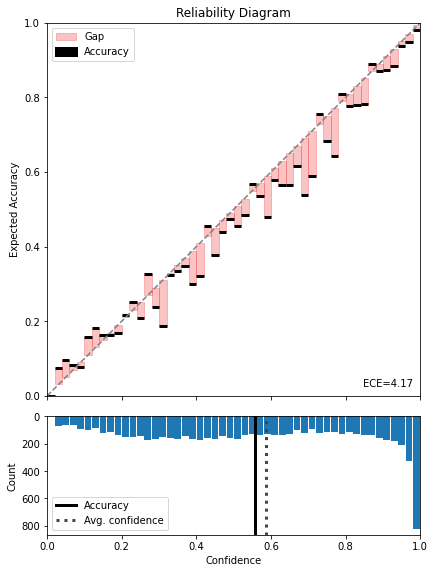

In [47]:
reliability_diagram(
    true_labels=labels,
    pred_labels=np.argmax(probs_mcdropout, axis=-1),
    confidences=probs_mcdropout[
        np.arange(len(probs_mcdropout)),
        np.argmax(probs_mcdropout, axis=-1)
                      ],
     num_bins=50
    )

In [48]:
# Compute scores for CIFAR100
cifar100_EH_cal_mcdrop, cifar100_HE_cal_mcdrop, cifar100_maxprob_cal_mcdrop = compute_scores_mcdropout(
    model_drop, cifar100_valloader, N_MC_DROP_SAMPLES, device)

# Compute scores for CIFAR10
cifar10_EH_cal_mcdrop, cifar10_HE_cal_mcdrop, cifar10_maxprob_cal_mcdrop = compute_scores_mcdropout(
    model_drop, cifar10_valloader, N_MC_DROP_SAMPLES, device)

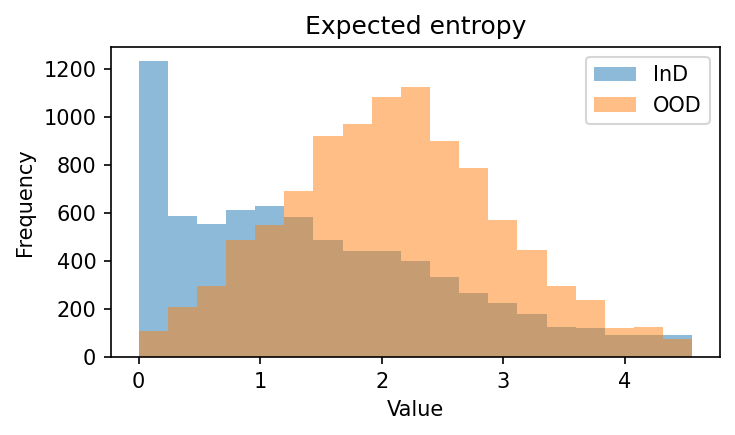

ROC AUC:  0.689


In [49]:
plot_histogram_eq_width(data1=cifar100_EH_cal_mcdrop, data2=cifar10_EH_cal_mcdrop, title="Expected entropy")

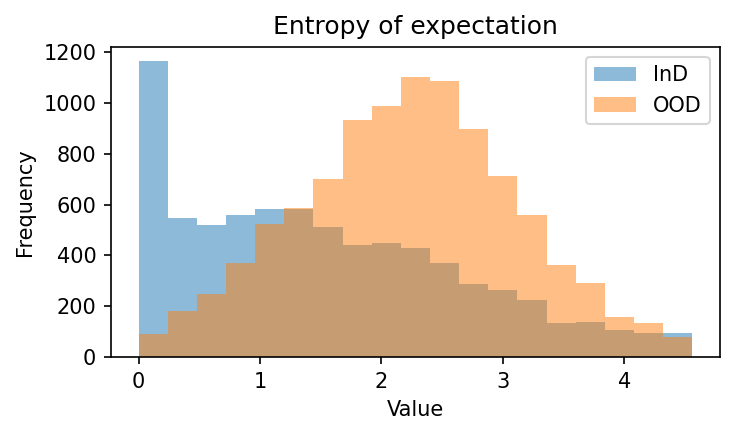

ROC AUC:  0.694


In [50]:
plot_histogram_eq_width(data1=cifar100_HE_cal_mcdrop, data2=cifar10_HE_cal_mcdrop, title="Entropy of expectation")

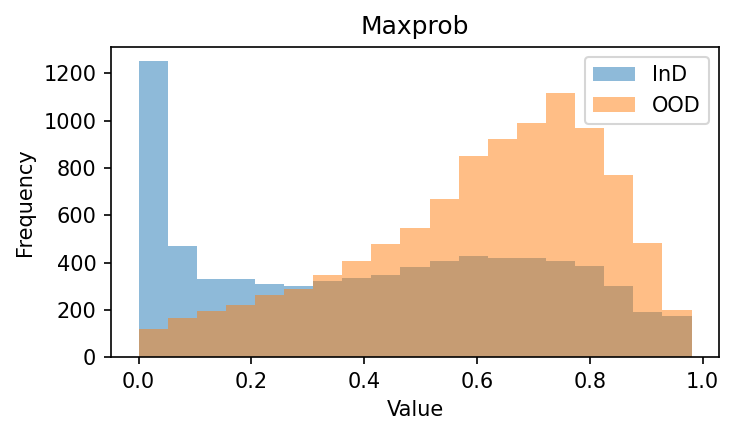

ROC AUC:  0.682


In [51]:
plot_histogram_eq_width(data1=cifar100_maxprob_cal_mcdrop, data2=cifar10_maxprob_cal_mcdrop, title="Maxprob")

# Stochastic Weight Averaging Gaussian (SWAG)

https://arxiv.org/pdf/1902.02476.pdf

Maddox, Wesley J., et al. "A simple baseline for bayesian uncertainty in deep learning." Advances in neural information processing systems 32 (2019).

In [52]:
!pip install gpytorch

In [53]:
from swa_gaussian.swag.posteriors import SWAG
from swa_gaussian.swag.utils import bn_update
from tqdm.auto import tqdm

/home/nkotelevskii/github/helpers/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [54]:
model_conf = PreResNet20()
base_model = model_conf.base

In [55]:
swag_model = SWAG(base=base_model)

In [56]:
swag_model = SWAG(
    model_conf.base,
    no_cov_mat=False,
    max_num_models=20,
    *model_conf.args,
    num_classes=100,
    **model_conf.kwargs
).to(device)

In [57]:
swag_model.load_state_dict(torch.load('./swag-300.pt', map_location=device)['state_dict'])

In [64]:
N_SWAG_SAMPLES = 20

In [60]:
def collect_labels_and_probs_swag(swag_model_, dataloader, n_samples, device):
    all_labels = []
    all_probs = []
    with torch.no_grad():
        for data in tqdm(dataloader):
            images, labels = data[0].to(device), data[1].to(device)

            prob_samples = []
            for _ in range(n_samples):
                swag_model_.sample()
                bn_update(cifar100_calloader, swag_model_)
                swag_model_.eval()
                outputs = swag_model_(images)
                probs = softmax(outputs, dim=1)
                prob_samples.append(probs.cpu().numpy()[None])

            all_labels.append(labels.cpu().numpy())
            all_probs.append(np.mean(np.vstack(prob_samples), axis=0))
    return np.hstack(all_labels), np.vstack(all_probs)

In [61]:
labels, probs_swag = collect_labels_and_probs_swag(swag_model_=swag_model,
                                                 dataloader=cifar100_valloader,
                                                 n_samples=N_SWAG_SAMPLES, device=device)

100%|██████████████████████████████████████████████| 75/75 [09:26<00:00,  7.56s/it]


/home/nkotelevskii/github/helpers/./reliability-diagrams/reliability_diagrams.py:177: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels(new_ticks)


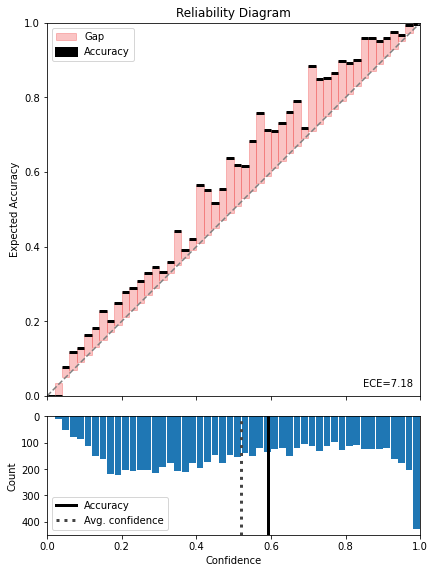

In [62]:
reliability_diagram(
    true_labels=labels,
    pred_labels=np.argmax(probs_swag, axis=-1),
    confidences=probs_swag[
        np.arange(len(probs_swag)),
        np.argmax(probs_swag, axis=-1)
                      ],
     num_bins=50
    )

In [67]:
# Compute the entropy and MaxProb scores
def compute_scores_swag(swag_model_, data_loader, n_samples, device):
    mean_entropy_scores = []
    entropy_mean_scores = []
    maxprob_scores = []
    bald = []
    with torch.no_grad():
        for data in tqdm(data_loader):
            images, _ = data
            images = images.to(device)

            single_model_probabilities = []
            for _ in range(n_samples):
                swag_model_.sample()
                bn_update(cifar100_calloader, swag_model_)
                swag_model_.eval()
                outputs = swag_model_(images)
                probabilities = F.softmax(outputs, dim=1).cpu().numpy()
                single_model_probabilities.append(probabilities[None])

            entropy_mean_scores.extend(entropy(np.mean(np.vstack(single_model_probabilities), axis=0), axis=1).tolist())
            mean_entropy_scores.extend(np.mean(entropy(np.vstack(single_model_probabilities), axis=-1), axis=0).tolist())
            maxprob_scores.extend((1 - np.max(np.mean(np.vstack(single_model_probabilities), axis=0), axis=1)).tolist())

    return mean_entropy_scores, entropy_mean_scores, maxprob_scores

In [68]:
# Compute scores for CIFAR100
cifar100_EH_cal_swag, cifar100_HE_cal_swag, cifar100_maxprob_cal_swag = compute_scores_swag(
    swag_model, cifar100_valloader, N_SWAG_SAMPLES, device)

# Compute scores for CIFAR10
cifar10_EH_cal_swag, cifar10_HE_cal_swag, cifar10_maxprob_cal_swag = compute_scores_swag(
    swag_model, cifar10_valloader, N_SWAG_SAMPLES, device)

100%|████████████████████████████████████████████| 100/100 [12:21<00:00,  7.41s/it]


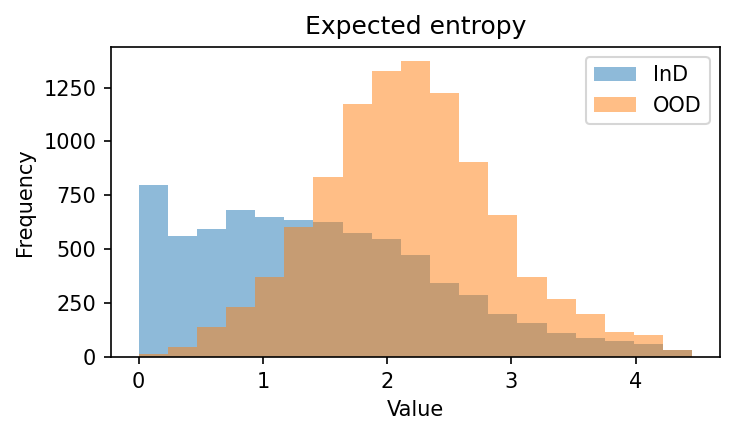

ROC AUC:  0.731


In [69]:
plot_histogram_eq_width(data1=cifar100_EH_cal_swag, data2=cifar10_EH_cal_swag, title="Expected entropy")

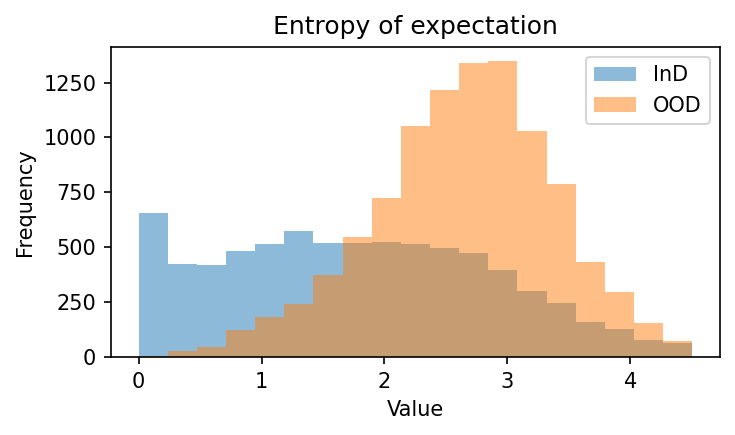

ROC AUC:  0.739


In [70]:
plot_histogram_eq_width(data1=cifar100_HE_cal_swag, data2=cifar10_HE_cal_swag, title="Entropy of expectation")

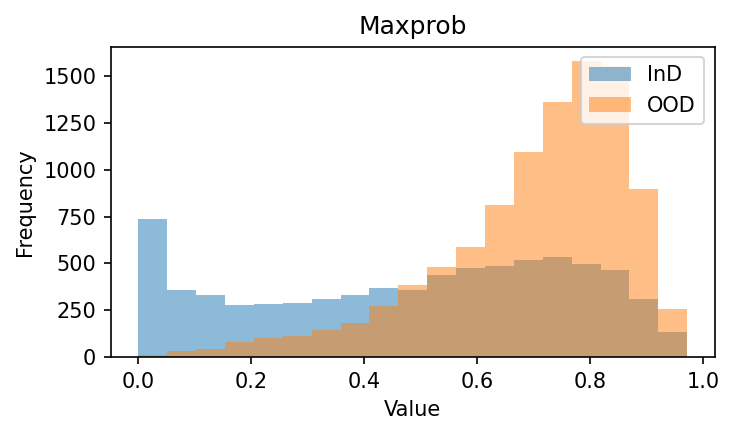

ROC AUC:  0.731


In [72]:
plot_histogram_eq_width(data1=cifar100_maxprob_cal_swag, data2=cifar10_maxprob_cal_swag, title="Maxprob")

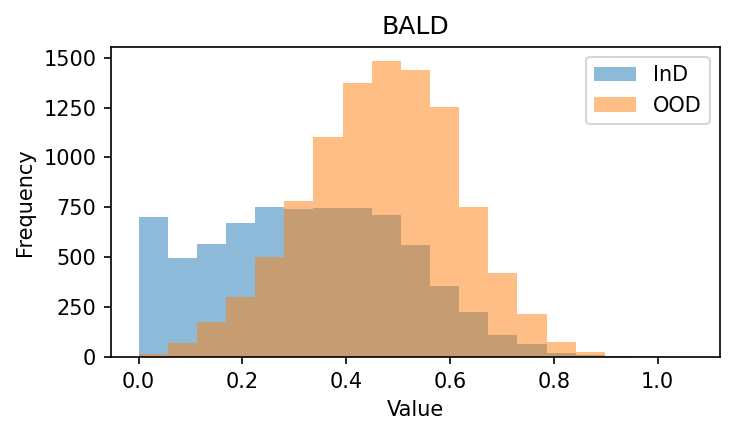

ROC AUC:  0.725


In [74]:
plot_histogram_eq_width(data1=np.array(cifar100_HE_cal_swag) - np.array(cifar100_EH_cal_swag),
                        data2=np.array(cifar10_HE_cal_swag) - np.array(cifar10_EH_cal_swag), title="BALD")

# PostNet / NatPN

https://arxiv.org/pdf/2105.04471.pdf

Charpentier, Bertrand, et al. "Natural Posterior Network: Deep Bayesian Uncertainty for Exponential Family Distributions." arXiv preprint arXiv:2105.04471 (2021).

# NUQ

In [1]:
from NUQ.nuq import NuqClassifier

/home/nkotelevskii/github/helpers/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-07-21 18:00:15,526	INFO util.py:159 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


ModuleNotFoundError: No module named 'ray.worker'